## Project ADA Milestone 2: Exploratory Analysis

**Importing libraries**

For this Milestone, we mainly used Pandas in order to do exploratory analysis. For mathematical operations, and arrays, we used NumPy, and finally for plotting we used Matplotlib and Seaborn. We also used the re library when using regular expression to filter some values.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

**Loading the dataset**

In [93]:
df = pd.read_csv('en.openfoodfacts.org.products.csv', sep="\t", encoding="utf-8", low_memory=False)

In [94]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see from here that there is a lot of information, and it seems that there is a lot of NaN values for certain columns.

More precisely, we can compute the number of columns in the dataframe:

In [95]:
print('Number of columns in the DataFrame:', df.columns.size)

Number of columns in the DataFrame: 173


There are many features, but we definitely won't work with all of them for the purpose of this project.

As we explore the dataset, we will only keep a few columns from all those we have at our disposal.

**NaN proportion for each column**

As mentioned earlier, it looks like there are many NaN values. Let's see that. Here we compute the proportion of NaN values for each columns, and only plot the columns that have less than 50% of NaNs.

Number of columns that have a proportion of NaN less than 50%:  30 / 173 columns.


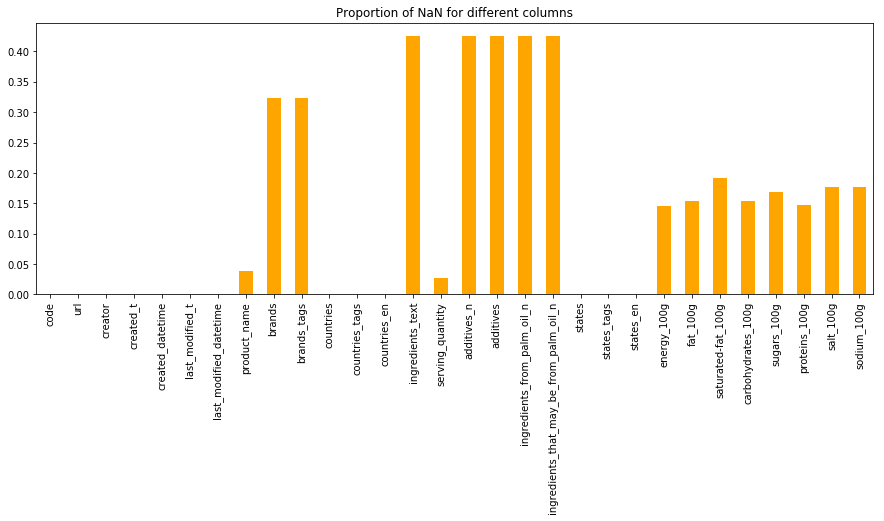

In [97]:
# Compute the proportion of NaN per column
nan_proportion = df.isnull().mean(axis=0)

# Store the columns for which there is less than 50% of NaN
nan_proportion_50 = nan_proportion[nan_proportion<0.5]
print('Number of columns that have a proportion of NaN less than 50%: ', 
      nan_proportion_50.size, '/', df.columns.size, 'columns.')

# Plot
plt.figure(figsize=(15, 5))
nan_proportion_50.plot(kind='bar', color='orange')
plt.title('Proportion of NaN for different columns')

plt.show()

Quite surprising! Actually, only 30 columns are more than half filled on the 173 that we have at our disposal. This suggest that maybe we will need to review some of things we planned to do because of the missing values. Indeed, if a huge amount of values are missing, we won't get very precise insights about the data for these columns.

**Choosing the columns to keep**

Now let's see with what columns we are going to work with. Of course, we keep the information about the products such as the name, brand, url. 

Then we also want to keep the information about the countries, packaging and labels, since it was one of the main focus of the project.

We will also keep all those related to the composition of the products(serving quantity, additives, fat, sugar, ...) as it will help us get insights about which country eats what.



In [99]:
# Columns that we keep for the exploratory analysis
cols = ['product_name', 'url', 'brands_tags', 'countries_en', 'origins', 'serving_quantity', 'additives_n', 
        'fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'labels', 'packaging']

In [101]:
# Filter to only keep the columns we need
df = df[cols]

# For columns that contain strings, set all characters to lower
df['countries_en'] = df['countries_en'].str.lower()
df['origins'] = df['origins'].str.lower()
df['packaging'] = df['packaging'].str.lower()

In [102]:
def without_nan(df, column):
    return df[~df[column].isnull()]

In [103]:
def splitDataFrameList(df, target_column, separator):
    """df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split

    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    """
    def splitListToRows(row, row_accumulator, target_column, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

**Import - Export**

As a first analysis, we will try to visualize which countries import and export, for the main countries in the dataset.

First, we split the 'countries' and 'origins' columns, since they may contain more than one country.

In [104]:
df = splitDataFrameList(without_nan(df, 'countries_en'), 'countries_en', ',')
df = splitDataFrameList(without_nan(df, 'origins'), 'origins', ',')

In [105]:
print('New shape of our DataFrame:', df.shape)

New shape of our DataFrame: (60114, 16)


As we can see, we end up with quite a lot more data when splitting to get all the countries.

Now let's get the destination and origin countries for the products, and try to first visualize which are the top destination countries:

In [128]:
dest_count = df['countries_en'].value_counts()

We plot below the top-25 destination countries. Note that since France has a significantly higher number of products (this is a french dataset), we also plot in the log scale.

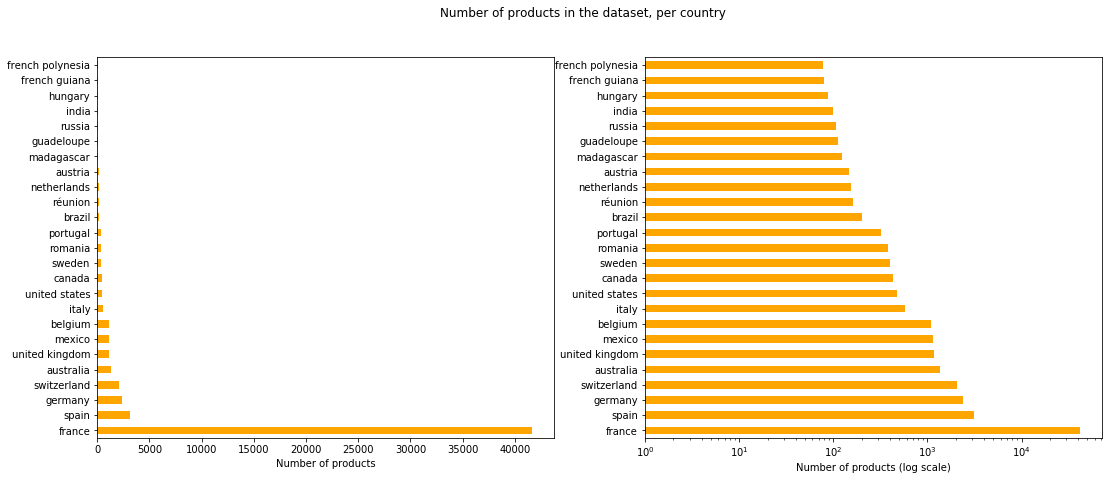

In [129]:
# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot the count of the products for each destination country
dest_count[:25].plot(kind='barh', color='orange', ax=ax1)
ax1.set_xlabel('Number of products')

# Plot again in log scale
dest_count[:25].plot(kind='barh', color='orange', ax=ax2, log=True)
ax2.set_xlabel('Number of products (log scale)')

f.suptitle('Number of products in the dataset, per country')
plt.show()

Not surprinsingly, the top countries are mainly those from Europe (again, the dataset focuses a lot on France and Europe), but we can also see the US abd Mexico for example.

In the remaining part of the notebook, we decided to focus our analysis on the countries that have the most products in their inventory.<br/>
So we will keep those top countries, and we will do the analyses on the first 15.

In [108]:
top_15 = dest_count[:15].index

Here, we will visualize the origins and destinations, for the top 15 countries. We chose to represent this information as a heatmap. 
For each pair of countries, we compute the number of food products for that pair and add one to the corresponding cell in a matrix representing those pairs.

After the matrix is filled with the counts of the different pairs, we use the heatmap() function of Seaborn to visualize the results.

In [135]:
def compute_heatmap(df):
    """Given a dataframe, compute a 
    heatmap matrix for import-export
    analysis"""
    
    # Create the matrix that will contain the counts
    matrix = pd.DataFrame(np.zeros((15, 15)), index=top_15, columns=top_15)

    # Fill in the matrix (for the top countries)
    for idx, row in df.iterrows():
        origin = row['origins']
        destination = row['countries_en']
        if destination in top_15 and origin in top_15:
            matrix.at[origin, destination] += 1
    return matrix

In [131]:
def plot_heatmap(matrix):
    """Plot the given matrix as a heatmap"""
    
    # Create subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Use Seaborn to plot a heatmap using the matrix
    sns.heatmap(matrix, linewidth=0.5, cmap='Reds', ax=ax1)
    ax1.set_ylabel('Origin Country')
    ax1.set_xlabel('Destination Country')

    # Plot again in log scale
    sns.heatmap(np.log(matrix+1), linewidth=0.5, cmap='Reds', ax=ax2)
    ax2.set_ylabel('Origin Country')
    ax2.set_xlabel('Destination Country')

    f.suptitle('Import-Export count between countries')
    plt.show()

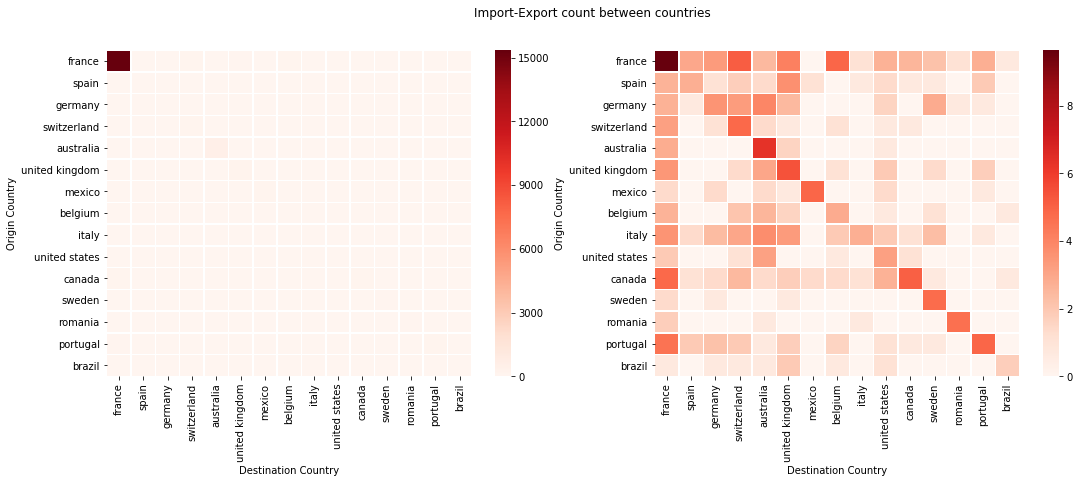

In [132]:
plot_heatmap(compute_heatmap(df))

As France has a count that is a lot larger, we also plotted on the right with a log scale to get better insights. What we see from this plot is very interesting. 

With this dataset, it looks like many countries actually produce their own food. Again, as France has always more data in this dataset, we see that France import and export to many countries. This may definitely be biased, and that's why we prefer to focus also on the other countries.

Australia and UK also produce a lot of their own food. As big exporters, we spot Spain, Germany, Italy and Portugal, which makes sens for Europe. As importers, the plot suggests that Germany, Switzerland, Australia and UK are the main ones.

**Additives per country**

In this part, we focus on an interesting analysis that aim to see which are the countries that eat with the biggest number of additives.

In order to compute that, we will make use of the 'additives_n' columns, and again the data about the countries.

In [122]:
additives_mean = df.groupby('countries_en').mean()['proteins_100g']

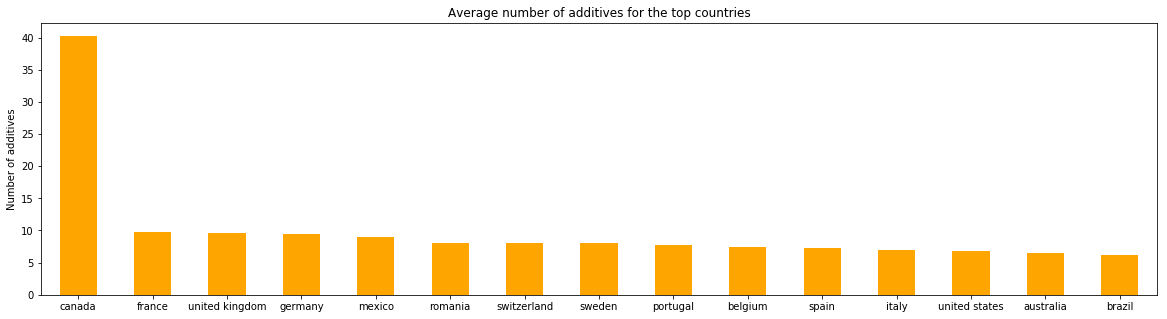

In [123]:
additives_mean.loc[top_15].sort_values(ascending=False).plot(kind='bar', color='orange', figsize=(20, 5), rot=0)
plt.ylabel('Number of additives')
plt.title('Average number of additives for the top countries')
plt.show()

**Packaging and BIO label**

In this part, we'll try to see what type of packages is the most used throughout the world. We will then have a look at the most used packages in each of our top 15 countries.

First, we compute, in percentage, the most used packages and plot the top 10.

In [16]:
df = splitDataFrameList(without_nan(df, 'packaging'), 'packaging', ',')

In [81]:
def plot_most_used_packaging(df):
    most_used_packaging = df.groupby('packaging').size().sort_values(ascending=False)
    most_used_packaging /= most_used_packaging.sum()

    most_used_packaging[:10].plot(kind='barh', color='orange')

    plt.xlabel('Proportion (in %)')
    plt.show()

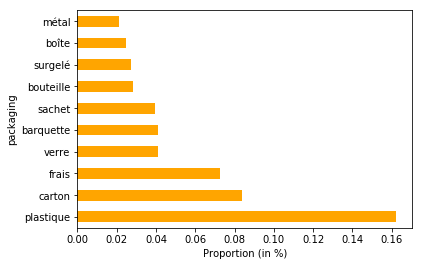

In [82]:
plot_most_used_packaging(df)

The name of the types of packages are in French, but what we see is that we mostly use plastic. In second place we have the paperbox, and after we see glass and bottles. 

(Again here, we ask the reader to keep in mind that this is a French dataset, and so it may not reflect the actual worldwide trends.)

Let's see now, for each of our top countries, the two types of packages they use the most:

In [90]:
def display_top2_packages(df):
    """Display the 2 most used packages
    for the top 15 countries"""
    
    # First group by country and packaging, then get frequency of packaging and sort these
    most_used_packaging_per_country = df.groupby(['countries_en', 'packaging']) \
                                        .size() \
                                        .sort_values() \
                                        .groupby(level=0) \
                                        .tail(2)
    
    # Return a dataframe with the country names sorted
    return pd.DataFrame(most_used_packaging_per_country.loc[top_15]) \
                    .drop(columns=0, axis=1) \
                    .sort_values('countries_en')

In [89]:
display_top2_packages(df)

Empty DataFrame
Columns: []
Index: [(australia, plastic), (australia, box), (belgium, plastique), (belgium, carton), (brazil, garrafa), (brazil, pacote), (canada, plastique), (canada, frais), (france, plastique), (france, carton), (germany, kunststoff), (germany, glas), (italy, plastica), (italy, carta), (mexico, botella de plastico), (mexico, plastico), (portugal, cartão), (portugal, plástico), (romania, pet), (romania, folie alimentara), (spain, bolsa de plástico), (spain, refrigerado), (sweden, carton), (sweden, plastic), (switzerland, carton), (switzerland, plastique), (united kingdom, plastic), (united kingdom, plastique), (united states, bottle), (united states, plastic)]

Not surprisingly, most of them use plastic the most. The only country that doesn't report plastic directly is Romania, which have plastic foil and Pet.

An interesting question to ask is "Do we see the same trend when filtering and only keeping the products labeled as BIO?".

This is what we will do just below. But first, we need to define what a bio product is. For that, the column `labels` will be useful, since it contains all the information we need to only keep the BIO products.

So using that column, we keep the products that contain labels such as "bio", "organic" or "AB". All these refer to product that are supposed to be biological. We use regular expression to filter out the products.

In [17]:
# Select products with an organic label
label_bio = df[
    df['labels'].str.contains("Bio", na = False, flags = re.IGNORECASE)
  | df['labels'].str.contains("Organic", na = False, flags = re.IGNORECASE)
  |  df['labels'].str.contains("\bAB\b", na = False, flags = re.IGNORECASE)
    ]

We plot again to get the proportion of the top 10 types of packaging:

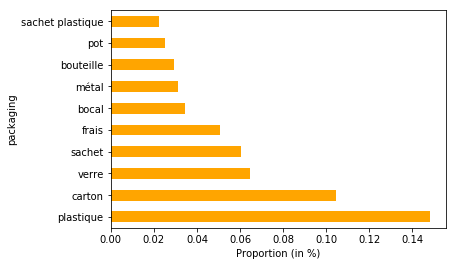

In [83]:
plot_most_used_packaging(label_bio)

Not quite what we would have like to find out! It seems like plastic is still the most used. But let's check the 2 most used packages for BIO products for our top 15.

In [86]:
display_top2_packages(label_bio)

Empty DataFrame
Columns: []
Index: [(australia, plastic), (australia, plastic bottle), (belgium, carton), (belgium, verre), (brazil, métal), (brazil, verre), (canada, sous-vide), (canada, sac), (france, plastique), (france, carton), (germany, kunststoff), (germany, glas), (italy, plastica), (italy, tubo di plastica pp5), (mexico, plástico), (portugal, plástico), (portugal, tetra pak), (romania, tetra pak), (romania, pahar plastic), (spain, refrigerado), (spain, bolsa de plástico), (sweden, carton), (sweden, plastic), (switzerland, carton), (switzerland, plastique), (united kingdom, chilled), (united kingdom, plastic), (united states, plastic), (united states, bag)]

Quite different! Indeed, there is actually still a lot of plastic, but we can see packaging like tetrapack or paperbox, which are a lot better for the environment.

**Are the BIO produts local?**

Finally, we use the heatmap function of the import export to see for our top 15 countries wether for the BIO products, they are actually local.

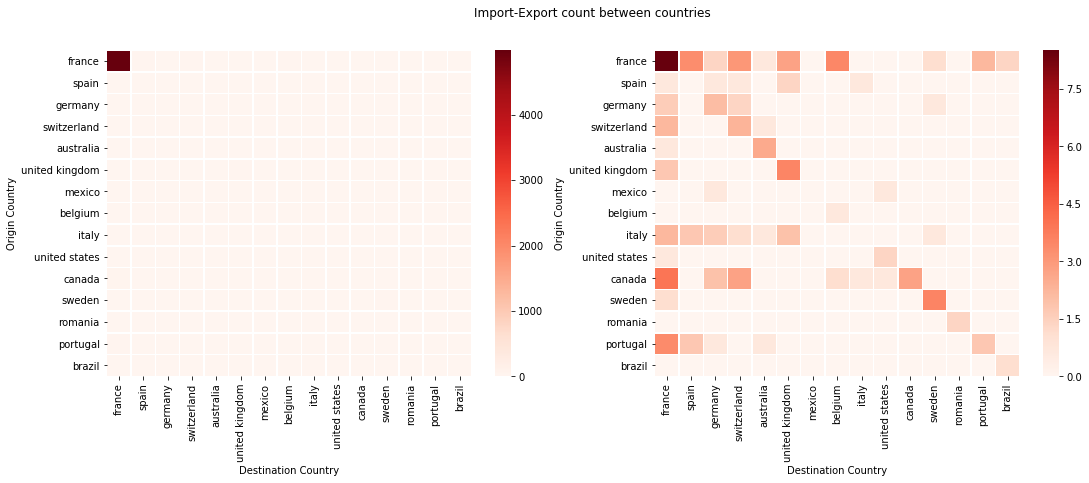

In [134]:
plot_heatmap(compute_heatmap(label_bio))

Again, if we don't look at France here, we can see that most country eat BIO product that come from within the country (look at the diagonal on the heatmap). But we also see that not all of them eat local. For example, Mexico, Italy, or the US don't seem to do it.

We see that Italy export a lot of its BIO products to countries in Europe.

**Plans for Milestone 3**

For the 3rd milestone, we mainly plan to:

- Add visualization part (world map, with the information we got from this milestone) &rarr; For the 2nd of December

- Perform the machine learning part with the images for the BIO products (to see if there are recurrent patterns or dominant colors) &rarr; For the 7th of December

- Choose between data story or report and complete it &rarr; For the 14th of December

- Complete the missing parts and prepare for the final submission &rarr; For the 16th of December


**Plans for the presentation**

For the presentation, we plan to:

- Give an introduction about the problem of how the food travels, more about packaging

- Explain what our project was about (where the food comes from, biological products & packaging)

- Show and explain the different insights we got together with the maps of the world

- Show the machine learning part and indicate the patterns and dominant colors we found for the biological products